# Propósito

Este notebook tem como objetivo realizar uma análise exploratória de algumas colunas de interesse das medições dos sensores de qualidade do ar.

O principal objetivo será preencher alguns valores nulos utilizando a função interpolate()

Mas para não enviesar muitos dados preencheremos apenas os valores em que a quantidade de valores nulas no dia semana menor que 7


# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC/sensores-2011-2021/medicao-sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC/sensores-2011-2021/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

<ipython-input-6-f9a423e0dd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
<ipython-input-6-f9a423e0dd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
<ipython-input-6-f9a423e0dd73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[(df_sensor_interest['ano'] > 2011) & (df_sensor_interest['ano'] < 2020)]

In [8]:
#@title Filtrando por SÃO CRISTÓVÃO
df_sensor_sao_cristovao = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO SÃO CRISTÓVÃO']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação São Cristóvão
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva

In [16]:
df_sensor_sao_cristovao['chuva'].describe()

,chuva
count,67705.000000
mean,0.094785
std,0.853700
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,45.400000


In [17]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 1210


In [18]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['chuva_nulos_no_dia'] = (
    df_sensor_sao_cristovao['chuva'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-18-6b87b5826e6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['chuva_nulos_no_dia'] = (


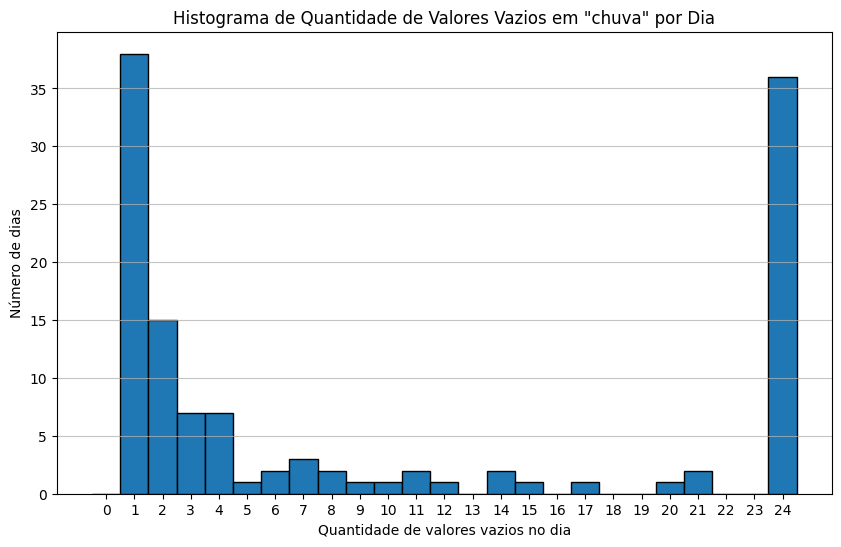

In [19]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [20]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_sao_cristovao['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['chuva'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'chuva'] = df_sensor_sao_cristovao[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

134 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 11% de dados


In [21]:
df_sensor_sao_cristovao['chuva'].describe()

,chuva
count,67839.000000
mean,0.095183
std,0.854874
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,45.400000


### Temperatura

In [10]:
df_sensor_sao_cristovao['temp'].describe()

,temp
count,61214.000000
mean,26.737429
std,4.760297
min,0.000000
25%,23.320000
50%,26.230000
75%,29.550000
max,49.080000


In [11]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7701


In [12]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['temp_nulos_no_dia'] = (
    df_sensor_sao_cristovao['temp'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-12-ef066d6eef06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['temp_nulos_no_dia'] = (


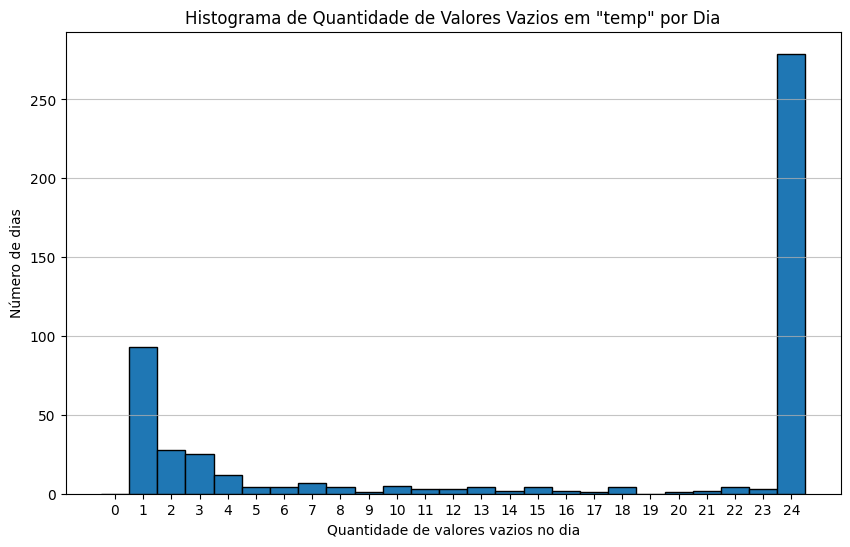

In [13]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [14]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_sao_cristovao['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['temp'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'temp'] = df_sensor_sao_cristovao[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

316 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 4% de dados


In [15]:
df_sensor_sao_cristovao['temp'].describe()

,temp
count,61530.000000
mean,26.738788
std,4.763518
min,0.000000
25%,23.320000
50%,26.230000
75%,29.570000
max,49.080000


### Umidade relativa

In [22]:
df_sensor_sao_cristovao['ur'].describe()

,ur
count,57337.000000
mean,72.011567
std,17.116493
min,0.000000
25%,60.500000
50%,73.400000
75%,84.970000
max,100.000000


In [23]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 11578


In [24]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['ur_nulos_no_dia'] = (
    df_sensor_sao_cristovao['ur'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-24-ebfb2a61a1f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['ur_nulos_no_dia'] = (


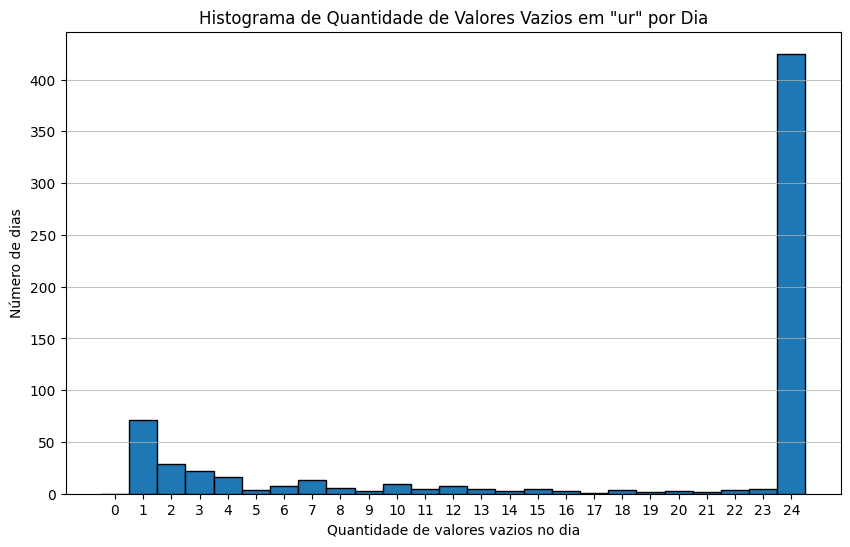

In [25]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [26]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_sao_cristovao['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['ur'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'ur'] = df_sensor_sao_cristovao[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

321 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 3% de dados


In [27]:
df_sensor_sao_cristovao['ur'].describe()

,ur
count,57658.000000
mean,72.002196
std,17.118301
min,0.000000
25%,60.480000
50%,73.380000
75%,84.970000
max,100.000000


### Monóxido de carbono

In [28]:
df_sensor_sao_cristovao['co'].describe()

,co
count,64893.000000
mean,0.248943
std,0.340978
min,0.000000
25%,0.070000
50%,0.140000
75%,0.280000
max,4.730000


In [29]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4022


In [30]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['co_nulos_no_dia'] = (
    df_sensor_sao_cristovao['co'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-30-9333977d84cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['co_nulos_no_dia'] = (


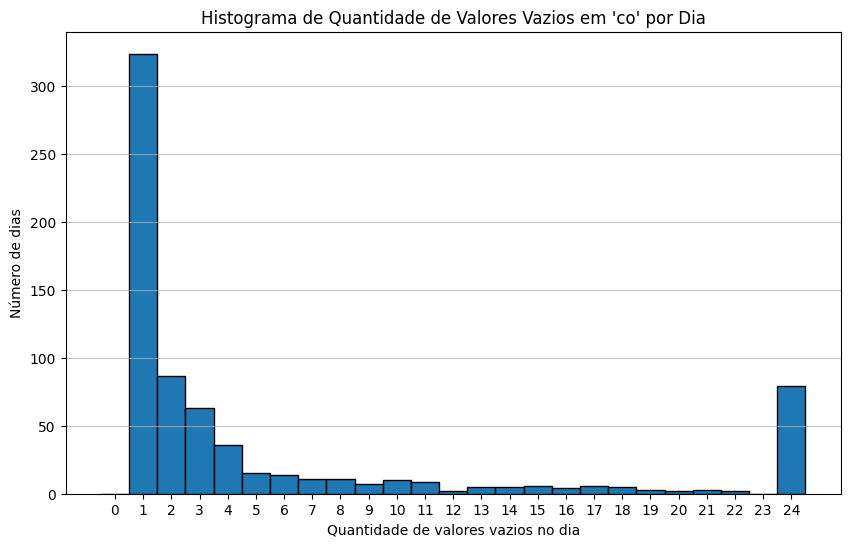

In [31]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [32]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_sao_cristovao['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['co'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'co'] = df_sensor_sao_cristovao[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

990 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 25% de dados


In [33]:
df_sensor_sao_cristovao['co'].describe()

,co
count,65883.000000
mean,0.249403
std,0.340738
min,0.000000
25%,0.070000
50%,0.150000
75%,0.280000
max,4.730000


### Dióxido de Enxofre Tijuca

In [52]:
df_sensor_sao_cristovao['so2'].describe()

,so2
count,61612.000000
mean,8.481747
std,10.351349
min,0.000000
25%,2.360000
50%,5.430000
75%,10.700000
max,184.180000


In [53]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7303


In [54]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['so2_nulos_no_dia'] = (
    df_sensor_sao_cristovao['so2'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-54-e698949ddd85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['so2_nulos_no_dia'] = (


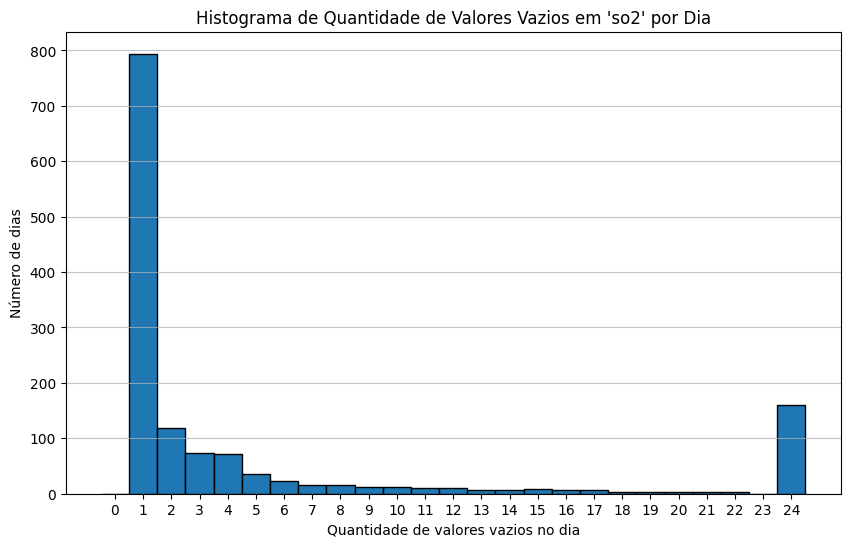

In [55]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [56]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_sao_cristovao['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['so2'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'so2'] = df_sensor_sao_cristovao[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1851 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 25% de dados


In [57]:
df_sensor_sao_cristovao['so2'].describe()

,so2
count,63463.000000
mean,8.495163
std,10.358805
min,0.000000
25%,2.360000
50%,5.440000
75%,10.710000
max,184.180000


### Ozônio Tijuca

In [58]:
df_sensor_sao_cristovao['o3'].describe()

,o3
count,65120.000000
mean,23.553661
std,26.764600
min,0.000000
25%,2.830000
50%,14.025000
75%,36.290000
max,251.260000


In [59]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 3795


In [60]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['o3_nulos_no_dia'] = (
    df_sensor_sao_cristovao['o3'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-60-2c4c55177fd8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['o3_nulos_no_dia'] = (


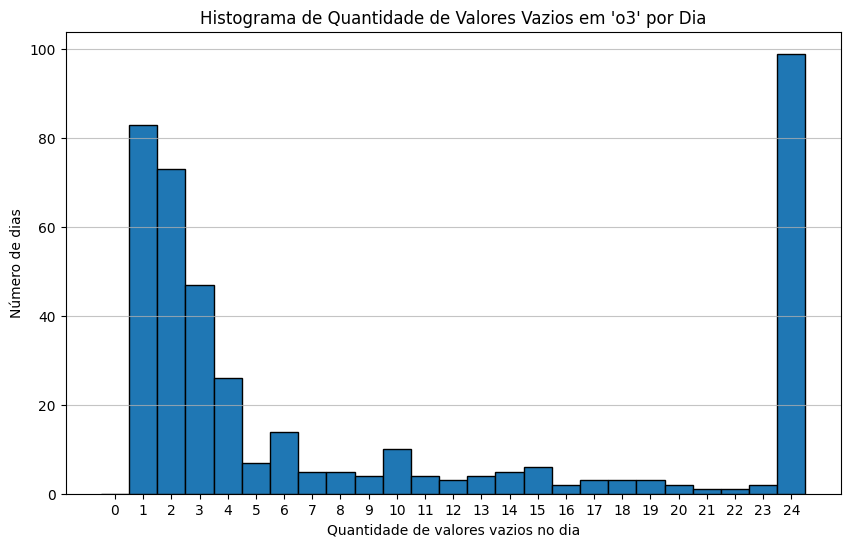

In [61]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [62]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_sao_cristovao['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['o3'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'o3'] = df_sensor_sao_cristovao[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

593 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 16% de dados


In [63]:
df_sensor_sao_cristovao['o3'].describe()

,o3
count,65713.000000
mean,23.636335
std,26.767099
min,0.000000
25%,2.870000
50%,14.180000
75%,36.400000
max,251.260000


### PM10 Tijuca

In [64]:
df_sensor_sao_cristovao['pm10'].describe()

,pm10
count,64072.000000
mean,33.463572
std,21.822756
min,0.000000
25%,18.000000
50%,29.000000
75%,43.000000
max,338.000000


In [65]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_sao_cristovao[df_sensor_sao_cristovao['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4843


In [66]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_sao_cristovao['pm10_nulos_no_dia'] = (
    df_sensor_sao_cristovao['pm10'].isnull()
    .groupby(df_sensor_sao_cristovao['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-66-35b4ee96769d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao['pm10_nulos_no_dia'] = (


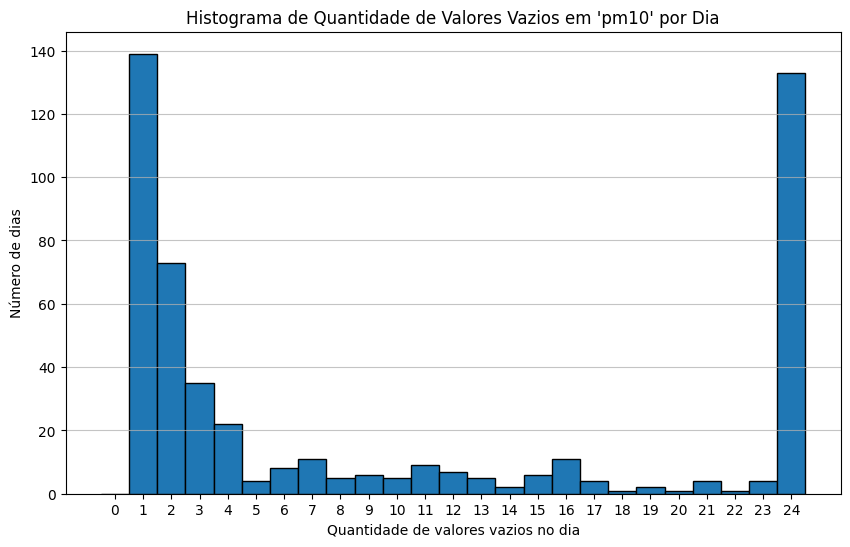

In [67]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_sao_cristovao[df_sensor_sao_cristovao['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [68]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_sao_cristovao['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_sao_cristovao[mask]['pm10'].isnull().sum()
df_sensor_sao_cristovao.loc[mask, 'pm10'] = df_sensor_sao_cristovao[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

546 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 11% de dados


In [69]:
df_sensor_sao_cristovao['pm10'].describe()

,pm10
count,64618.000000
mean,33.473948
std,21.827908
min,0.000000
25%,18.000000
50%,29.000000
75%,43.000000
max,338.000000


# Gerando CSV de saída com a estação de Tijuca preenchida


In [70]:
droping_columns = ['chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_sao_cristovao.drop(columns=droping_columns, inplace=True)

<ipython-input-70-823096be19a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_sao_cristovao.drop(columns=droping_columns, inplace=True)


In [71]:
df_sensor_sao_cristovao.to_csv('df_sensor_sao_cristovao_preenchido.csv', index=False)